# IN-STK5000 Credit Project

#### 02-10-2019
#### Bjørn Ivar Teigen, Mathieu Diaz, Jolynde Vis

### First: Exploring and preprocessing the data
We start by looking at the german credit data file. When we make a countplot of the outcome variable (which is whether a given loan was repaid, where 0 is no and 1 is yes), we see that the data is imbalanced.

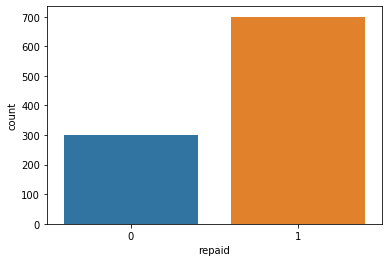

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline


features = ['checking account balance', 'duration', 'credit history',
            'purpose', 'amount', 'savings', 'employment', 'installment',
            'marital status', 'other debtors', 'residence time',
            'property', 'age', 'other installments', 'housing', 'credits',
            'job', 'persons', 'phone', 'foreign']
target = 'repaid'
df = pd.read_csv('./data/german.data', sep=' ',
                     names=features+[target])

df.loc[df['repaid'] == 2, 'repaid'] = 0
sns.countplot(x = df[target], data = df)



In [ ]:
numerical_features = ['duration', 'age', 'residence time', 'installment', 'amount', 'duration', 'persons', 'credits']
quantitative_features = list(filter(lambda x: x not in numerical_features, features))
X = pd.get_dummies(df, columns=quantitative_features, drop_first=True)
encoded_features = list(filter(lambda x: x != target, X.columns))




The percentage of the outcome being 0, or not repaid, is 30%, while the percentage for the outcome being 1, or repaid, is 70%.

Using one-hot encoding the categorical attributes are converted in order to be able to use them in the machine learning algorithm. Normalising is done in the models, and therefore not in the preprocessing.

### Second: Policy design
Designing a policy for giving or denying credit to individuals The choice for giving or denying credit to individuals is based on their probability for being credit-worthy. Given this probability, and taking into account the length of the loan, we can calculate the expected utility of giving a loan, using the formula

$$
E(U) = gain * p-amount*(1-p)
$$

Where amount is the loaned amount, and gain is the total amount of interest on the loan. p is the predicted probability of the loan being paid back. The interest is calculated using the following formula:

$$
amount*((1+interest_rate)**(duration)/-1)
$$

where duration is loan duration in months, and interest_rate is return per month in %/100.

In [7]:
def calculate_gain(self, X):
    return X['amount']*((1 + self.interest_rate)**(X['duration']) - 1)

def expected_utility(self, X):
    p = self.predict_proba(self.parse_X(X))
    gain = self.calculate_gain(X)
    expected_utilitiy = (gain.values*p.flatten()
                        -X['amount'].values*(1-p.flatten()))
    return expected_utilitiy

The probability is calculated by use of classification models.

We assume that the labels represent the actual outcome of each loan, i.e. either loans are fully paid back or defaulted. We also assume the labeling process is accurate, i.e there is no noise in the labeling process.

We've chosen to implement three different models so we can compare them. The models are kNN, random forest and a fully connected neural network.

#### kNN:
A kNN classifier with k=15 is used, pipelined with a standardscaler which subtracts the mean and scales input features to unit variance. The fit() function learns the means and standard deviations of each feature for the standardscaler, and then fits the kNN function to the training set. predict_proba() uses the in-build function in kNN from scikit learn.

#### Random forest:
Random forest does not scale the data. We use n=130 classifiers. predict_proba() uses the in-build function in random forest from scikit learn.

#### Neural network:
fit(): As a first layer for the model we use batch normalization. This centers and normalizes the input values. The main model is a simple fully connected artificial neural network with elu activations. We use L2 regularization. The final layer consists of a single neuron with a sigmoid activation. The network is trained using binary cross-entropy loss.

We do a cross-validation (on the training data only) grid search over these parameters:

In [ ]:
def fit(self, X, y):
    param_grid = {'layer_sizes': [[32, 16], [64, 16], [64,32,16,8]],
    'batch_size': [8],
    'epochs': [3],
    'interest_rate': [self.interest_rate],
    'optimizer': ['Adam'],
    'loss': ['binary_crossentropy'],
    'alpha': [1, 0.1, 0.01, 0.001, 0.0001]}
    self.model = GridSearchCV(NeuralBanker(), param_grid, cv=5, n_jobs=6)
    self.model.fit(X, y)

The scoring function for the grid search is the utility on the holdout set of the cross-validation.

The selected model is trained using a batch size of 8 and 3 epochs of training with the Adam optimizer. layer_sizes is [64, 16], and the l2 regularization alpha parameter is 0.01.

predict_proba(): This function merely outputs the result of running the trained network forward.

### Utility
Now we have models that are well trained and working. So we will be able to combine it with our policy for giving credit. We will retrieve the result of the function expected_utility(X). If the result is greater than 0, that is to say if we can make money with this loan, the action will take the value 1. If the value returned is 0 or negative, the loan must not be granted. Since we made a change of value at the beginning, we change the 0 to 2.

In [ ]:
def get_best_action(self, X):
    actions = (self.expected_utility(X) > 0).astype(int).flatten()
    actions[np.where(actions == 0)] = 2
    return actions

### Results of the policy
Running all models through the TestLending procedure produced the following results:

The table below shows an average utility per banker, over 5 runs with 0.5% and 5.0%, respectively, interest rate each month.

| Banker (class) | Amount <br/> (interest rate 0.5% / month) | Amount <br/> (interest rate 5% / month) |
|:------|:------:|:------:|
| Random Banker | -79560 | 841195 |
| kNN Banker  | 1591 | 1256564 |
| Random Forest Banker| 8837 | 1034688 |
| Neural Network Banker | 4816 | 1102298 |

## Part 2

### 2.1. Model evaluation

*Maximum* revenue can never be ensured, because there will always be an error rate in every machine learning model, and therefore there will always be some loss. However, by choosing a model with a low error on the data and by minimizing this error the revenue can be increased. The error can be minimized by optimizing the parameters of the model. 

To ensure an increase in revenue we compare the three different models (kNN, Random Forest and Neural Network) not only based on their accuracy score, but also on where their wrong predictions are located, seeing that some types of errors are more costly. In the case of credit loans, the *false positives* are a problem for the bank. False positives are the errors of the model where it falsely predicts a positive outcome, in our case that the loan will be repaid. This error is the most important to minimize, since this error costs the bank money. If the model falsely predicts a negative outcome, i.e. it predicts that the loan will not be repaid and therefore the credit loan will not be provided, it doesn’t cost the bank money. The confusion matrix gives the distribution of the predictions.  

| | Accuracy score | Confusion matrix |
|:------|:------:|:------:|
| kNN Banker | 0.62 | [19  **42**] <br/> [15 124] |
| Random Forest Banker | 0.645 | [31 **29**] <br/> [11 129] |
| Neural Network Banker | ? | ? |

The right-upper corner of the matrix (in bold) shows the false positives of the model. We see that the random forest predicts less false positives and has a higher accuracy score. We will continue with the random forest and optimize this model. 

### 2.2. Model optimization
The ROC (Receiver Operating Characteristics) curve of the model shows true positive rate (x-axis) and the false positive rate (y-axis) dependent on the threshold used (the curve). A curve to the top and left is a better model. 

In [ ]:
![alt text][logo]

[logo]: https://github.com/adam-p/markdown-here/raw/master/src/common/images/icon48.png "Logo Title Text 2"

In figure X we can see that the curve for the Random Forest model is directed to the top and left of the axis, showing a good model. 

However, since we are mostly interested in lowering the error of false positives of the model, whereas the false negatives are less important. The confusion matrix allows us to compute two metrics that deal with the false positives: 
* The specificity of the model, i.e. when the actual value is negative, how often is the prediction correct
* The precision of the model, i.e. when a positive value is predicted, how often is the prediction correct 

Table X shows the scores for the Random Forest on these metrics for different probability thresholds. 

|| Specificity | Precision |
|:------|:------:|:------:|
| Threshold $p>0.5$ | 0.381 | 0.761 |
| Threshold $p>0.7$ | 0.794 | 0.859 |

However, the downside to increasing the probability threshold is that the model predicts more false negatives, meaning less people get a loan. The next step will be to see how it affects the actual utility or whether we should use the utilities instead of the probabilities. We have not yet figured this out however… 

Increasing the threshold of the probability lowers the risk of the model being wrong.

### 2.3. Model risk

The risk of the model being wrong can be lowered by critically assessing the model’s performance. Beforehand, performance requirements for the model should be set in terms of accuracy score and acceptable error. These requirements are dependent on the data and the business model.

After setting these initial requirements, they should be tested. A common measure is to calculate the accuracy score and the confusion matrix of the model, which are discussed before in model evaluation. By optimizing the parameters of the model these measures can be optimized. The confusion matrix can be improved by adjusting the threshold of the probability. The accuracy score can (in this case) be improved with feature selection and tuning the parameters of the model. By using the best subset of attributes that explain the relationship of the independent variables and the outcome variable, there is less noise from independent variables that do not explain the outcome variable that well. We will look at feature selection further in the next section. The optimal parameters of the model can be found by plotting them against the accuracy score of the model. 

By using cross validation, where the data is divided in k parts and each part is used as training data and once as test data for the model, more generalized relationships between the input and outcome data are achieved. The lower the standard deviation of the error scores from the cross-validation is, the better the model performs, because it does not vary a lot with different subsets of training data. This will ensure that the model performs better on unseen data as well. 
Lastly, it is important to keep monitoring the model to make sure it’s working well, and regularly retrain the model when new data comes in, so that the model keeps up to date.


### 2.4. Limited or biased data

Cross-validation, as explained before, is also a good way to deal with limited data. Rather than splitting the data into a training and a test part, where we would end up with a small test subset to test the model on, the whole dataset is used to both train and test over different runs, therefore making optimal use of the whole dataset. 

Uncertainty arising from biased data is hard to take into account. By critically assessing the origin of the data and how the data is collected biases in the dataset can be estimated. If these biases are clear up front, the design of the model can be adapted so that it responds minimal to these biases. 

After making the model it should be checked whether it is biased against certain societal biases. Marr (Forbes, 2019) lists steps that could be taken to minimize the risk of preserving societal biases in AI. Among others, the article focuses on ensuring that the algorithm is coded so that it doesn’t respond to societal biases. More specifically, this means that when designing a machine learning algorithm, it is important, first, to choose your subset carefully. In other words, make sure the subset is representative for the population you are predicting something for. Since we don’t collect our own data for this report this point is a bit difficult, but when using feature selection it is important to consider the population we are predicting. Second, in feature selection, we have to make sure we only exclude features that don’t influence the outcome. Because random forests uses decisions trees, where every tree builds different subsets (of the data) until it understands and represents the relationship of the variables with the target variable, this model has a feature importance attribute in it. When we plot this attribute, it gives the following graph for our random forest model.


In [ ]:
insert image

The graph shows that duration, amount and age are the three most important features. However, due to the one-hot encoding, the graph is a bit hard to interpret. 

Another way to reduce a bias in the model is to monitor the performance of the model, thereby preventing that the model responds to societal biases. 